In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [35]:
# 3
#Create image generators for each of the three image data sets (train, validation, test). Use ImageDataGenerator to read / decode the images
#and convert them into floating point tensors. Use the rescale argument (and no other arguments for now) to rescale the tensors from values
#between 0 and 255 to values between 0 and 1.

# Normalize pixel values to [0, 1] for numerical stability
train_image_generator = ImageDataGenerator(rescale=1./255,)
validation_image_generator = ImageDataGenerator(rescale=1./255,)
test_image_generator = ImageDataGenerator(rescale=1./255,)

#For the *_data_gen variables, use the flow_from_directory method. Pass in the batch size, directory, target size ((IMG_HEIGHT, IMG_WIDTH)),
#class mode, and anything else required. test_data_gen will be the trickiest one. For test_data_gen, make sure to pass in shuffle=False to the
#flow_from_directory method. This will make sure the final predictions stay in the order that our test expects. For test_data_gen it will also
#be helpful to observe the directory structure.

# Create data generators for training, validation, and testing sets
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,  # Directory containing training images
    subset='training', # Indicates this is the training subset
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resizes images to a specific size
    batch_size=batch_size, # Number of images per batch
    class_mode='binary' # Indicates binary classification (e.g., cat vs. dog)
    )

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir, # Directory containing validation images
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
    )

test_data_gen = test_image_generator.flow_from_directory(
    PATH, # Directory containing test images
    classes = ['test'], # Indicates a single class for testing
    shuffle = False, # Ensures consistent order for testing
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


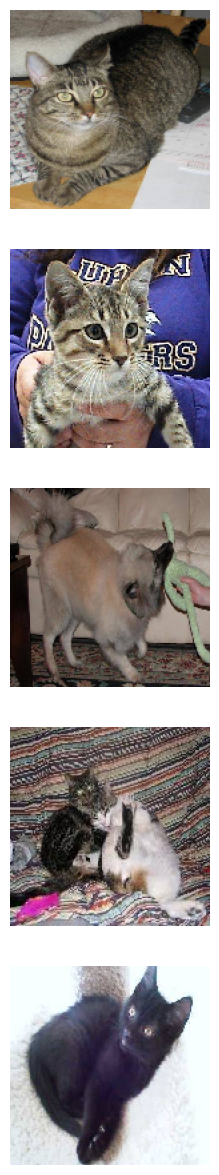

In [15]:
# 4
#The plotImages function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities
# list is optional. This code is given to you. If you created the train_data_gen variable correctly, then running this cell will plot five random
#training images.

def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [34]:
# 5
# Recreate the train_image_generator using ImageDataGenerator.
#Since there are a small number of training examples, there is a risk of overfitting. One way to fix this problem is by creating more training
#data from existing training examples by using random transformations.
#Add 4-6 random transformations as arguments to ImageDataGenerator. Make sure to rescale the same as before.
train_image_generator = ImageDataGenerator(
    rescale = 1./255, # Normalize pixel values to [0, 1]
    rotation_range = 25, # Randomly rotate images by up to 25 degrees
    shear_range = .15, # Randomly apply shearing transformations
    zoom_range = .20, # Randomly zoom images by up to 20%
    height_shift_range = .2, # Randomly shift images vertically by up to 20%
    horizontal_flip = True, # Randomly flip images horizontally
    fill_mode = 'nearest', # Fill in missing pixels when images are transformed
    validation_split = .2, # Reserve 20% of the data for validation
    )


Found 2000 images belonging to 2 classes.


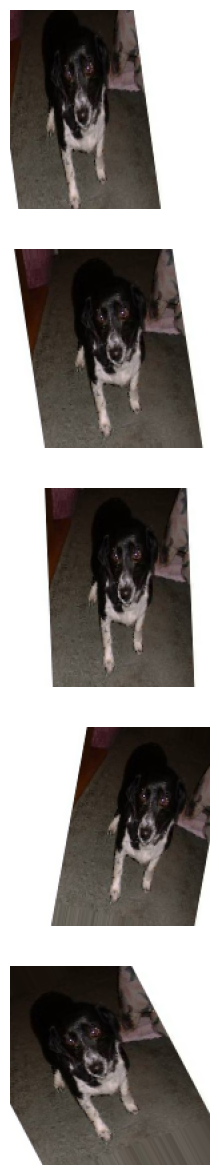

In [27]:
# 6
# You don't have to do anything for this cell. train_data_gen is created just like before but with the new train_image_generator. Then, a single
# image is plotted five different times using different variations.
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [36]:
# 7
# In this cell, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably
# involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

#Compile the model passing the arguments to set the optimizer and loss. Also pass in metrics=['accuracy'] to view training and validation accuracy
# for each training epoch.

model = Sequential()

# First convolutional layer
# 32 filters, 3x3 kernel size, ReLU activation, input shape for images
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)))
# 2x2 max pooling to reduce dimensionality
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
# 64 filters, 3x3 kernel size, ReLU activation
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the 2D feature maps to a 1D vector
model.add(Flatten())

# Fully connected layers

# Hidden layer with 64 neurons
model.add(Dense(64, activation = 'relu'))
# Output layer with 4 neurons (assuming 4 classes)
model.add(Dense(4, activation = 'sigmoid'))

# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function for multi-class classification
    optimizer='adam',  # Optimization algorithm
    metrics=['accuracy']  # Evaluation metric
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       5,308,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,328,132 (20.33 MB)

 Trainable params: 5,328,132 (20.33 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# 8
# Use the fit method on your model to train the network. Make sure to pass in arguments for x, steps_per_epoch, epochs, validation_data, and
# validation_steps.

# Train the model
history = model.fit(
    train_data_gen,  # Training data generator
    steps_per_epoch=total_train // batch_size,  # Steps per epoch based on total training data and batch size
    epochs=epochs,  # Number of training epochs
    validation_data=val_data_gen,  # Validation data generator
    validation_steps=total_val // batch_size,  # Validation steps based on total validation data and batch size
    verbose=1  # Display training progress as logs
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.5000 - loss: 3.3330 - val_accuracy: 0.4978 - val_loss: 0.8620
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5391 - loss: 0.8494 - val_accuracy: 0.5192 - val_loss: 0.8417
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.5669 - loss: 0.7524 - val_accuracy: 0.5134 - val_loss: 0.7315
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5312 - loss: 0.7066 - val_accuracy: 0.5865 - val_loss: 0.6514
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.6091 - loss: 0.6463 - val_accuracy: 0.6596 - val_loss: 0.6082
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.7969 - loss: 0.5250 - val_accuracy: 0.6154 - val_loss: 0.6666
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.6783 - loss: 0.5848 - val_accuracy: 0.6562 - val_loss: 0.6339
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - accuracy: 0.7266 - loss: 0.5308 - val_accuracy: 0.7308 - va

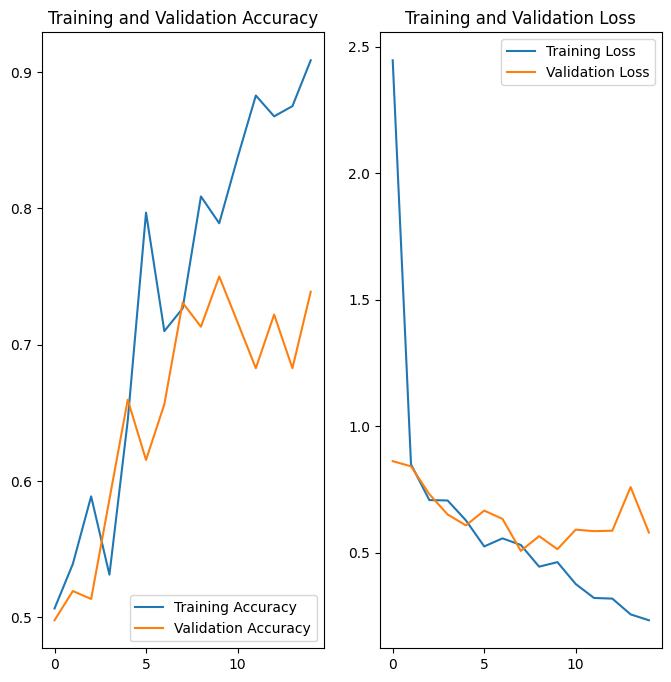

In [38]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
#Now it is time to use your model to predict whether a brand new image is a cat or a dog.

#In this cell, get the probability that each test image (from test_data_gen) is a dog or a cat. probabilities should be a list of integers.

#Call the plotImages function and pass in the test images and the probabilities corresponding to each test image.

#After you run the cell, you should see all 50 test images with a label showing the percentage of "sure" that the image is a cat or a dog. The
# accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a
# higher accuracy.

# Get the next batch of test images from the generator
test_images, _ = next(test_data_gen)

# Predict probabilities for each class using the model
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


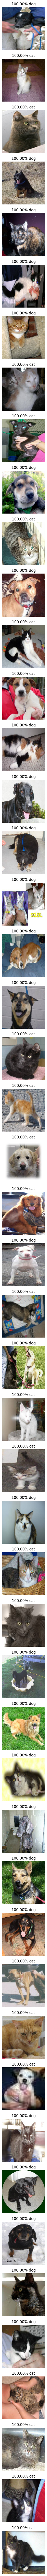

In [32]:
plotImages(test_images, probabilities=probabilities)

In [40]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
